# Power Outages
* **See the main project notebook for instructions to be sure you satisfy the rubric!**
* See Project 03 for information on the dataset.
* A few example prediction questions to pursue are listed below. However, don't limit yourself to them!
    * Predict the severity (number of customers, duration, or demand loss) of a major power outage.
    * Predict the cause of a major power outage.
    * Predict the number and/or severity of major power outages in the year 2020.
    * Predict the electricity consumption of an area.

Be careful to justify what information you would know at the "time of prediction" and train your model using only those features.

# Summary of Findings


### Introduction
In this project, we explore the major power outage data in the continental U.S. from January 2000 to July 2016 and use the classification prediction model to predict if an outage will be serious or not. Setting the median of customer affected as threshold, we used a Binarizer by labeling the outage with the customer affected larger than the median as 1 and 0 vice versa. We assigned the results as "Outcomes" in our dataset which also stands as our targeting feature. We decided to run the baseline model using one hot ecoding on categorical variable and dropped the features which has large amount (>300) of nan values since missingness does not help us to predict our outcome. Randomly splitting the data into 70% training set and 30% testing set, the baseline model gives us a train accuracy around 81% and test accuracy around 70% which can definitely be improved. In final model, we added the status of the population in our model and log transform IND.CUST.PCT in order to improve our model. We obtain a test accuracy around 76% which is definitely an improvement. Lastly, we did a fairness analysis to to check if our model is fair when evaluating the severity in coastal and inland states using permutation test on 
### Baseline Model
We dropped three features which had large amount of nan values thus leaving us 50 features to predict if the outage is serious or not. After dropping these features, we also dropped the rows that contained nan values to make it easier for us to predict our model. Later, we converted the features that are supposed to be quantitative from objects to float. We then apply one hot encoding to the categorical features and put the adjusted data into Column Transformer and Pipeline using the Decision Tree Classifier which gives us the test accuracy around 84% and test accuracy around 70% which definitely can be improved.

Below are the name of the features and whether it is nominal(N), ordinal(O), or quantitative(Q): 

'YEAR': O, 'MONTH': N, NERC.REGION': N 'CLIMATE.REGION': N, 'ANOMALY.LEVEL': Q, 'CAUSE.CATEGORY': N, 'CAUSE.CATEGORY': N, 'OUTAGE.DURATION': Q, 'CUSTOMERS.AFFECTED': Q, 'RES.PRICE': Q, 'COM.PRICE: Q, 'IND.PRICE': Q, 'TOTAL.PRICE': Q, 'RES.SALES': Q, 'COM.SALES': Q, 'IND.SALES': Q, 'TOTAL.SALES': Q, 'RES.PERCEN': Q, 'COM.PERCEN': Q, 'IND.PERCEN': Q, 'RES.CUSTOMERS': Q, 'COM.CUSTOMERS': Q, 'IND.CUSTOMERS': Q, 'TOTAL.CUSTOMERS': Q ,'RES.CUST.PCT': Q, 'COM.CUST.PCT': Q, 'IND.CUST.PCT': Q, 'PC.REALGSP.REL':Q, 'PC.REALGSP.CHANGE': Q, 'UTIL.REALGSP': Q, 'TOTAL.REALGSP': Q, 'UTIL.CONTRI': Q, 'PI.UTIL.OFUSA': Q,'POPULATION': Q, 'POPPCT_URBAN': Q, 'POPPCT_UC': Q, 'POPDEN_URBAN': Q, 'POPDEN_UC':Q, 'POPDEN_RURAL': Q, 'AREAPCT_URBAN': Q, 'AREAPCT_UC': Q, 'PCT_LAND': Q, 'PCT_WATER_TOT': Q, 'PCT_WATER_INLAND': Q, 'OUTAGE.START': O,'OUTAGE.RESTORATION': O, 'Outcome': O

### Final Model
In the final model, we added the feature POPULATION_CATEGORICAl which used the quatiles of population as thresholds to determine if the population is Very_Little_People, Little_People, Many_People or Very_Many_People. The reason for us to add this feature was because . After running the model, we obtain the train accuracy around 83% and test accuracy around 72% which is only a slightly improvement. We also find out one quantitative feature, IND.CUST.PCT, with large standard deviation and highly skewed which may cause a problem to our prediction; therefore, we log transform this feature using FunctionTransformer and repeated the steps as baseline model. After using GridSearchCV, we obtain the best max_depth to be 3 and obtain the test accuray around 76% which is an improvement comparing to our test accuracy in the baseline model.

### Fairness Evaluation
We evaluate our model for "fairness" on the 'U.S.State' subset of the data using a permutation test. We want to explore whether our model is fairer for inland states or costal state. Thus, we binarize our subset by setting the States that are inland as 'inland' and the States that are costal as 'costal'. Now my dataset is split into subsets: a costal subset and an inland subset. These are our X and Y.

Our null and alternative tests are states as below with the significance level of 0.01:

- Null Hypothesis: our model is fair, as the precision for my two subsets are roughly the same

- Alternative Hypothesis: our model is unfair, as the precision for the 'coastal' subset is different from the "inland" subset

We first created a column 'is_coastal', using classification from relavent [Wikipedia page] (https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_coastline). 

Here, our methodology is to shuffle the 'is_coastal' column and verify if our observative accuracy is similar enough to other permutated result by checking it poistion in the simulated distribution. Once we got the subsets of the data with no Null values, we ran our final model on the subset of the data and found the difference in accuracy score for the coastal and inland group in the model. Then we store this difference of score in an array. We ran this proccess of getting the test statistic 1000 times to get a distribution of test statistics. We found our p-value based on the proportion of test statistics above a pre-determined threshold. We chose our threshold to be 0.01. Comparing to our siginificance level 0.49 (<0.01), we fail to reject the null hypothesis and conclude that our model is fair when predicting the seriousness of the outage for coastal and inland states.


# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics

from sklearn.preprocessing import Binarizer 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

### Cleaning and EDA
It is vital for us to do data cleaning before performing EDA and further testing since the original data contains invalid column names and some invalid rows.

In [2]:
#Read in Excel file
df = pd.read_excel('outage.xlsx')
df.head()

<ipython-input-2-47f97813fd93>:2: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  df = pd.read_excel('outage.xlsx')


,Major power outage events in the continental U.S.,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56
0,Time period: January 2000 - July 2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Regions affected: Outages reported in this dat...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,variables,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND


In [3]:
# Get all the variables
variables = df.loc[4]
# Set the column names to variables
df.columns = variables
# Extract the units for the variables
units = df.loc[5].values[1:]
# Drop the useless columns 
df = df.drop([0, 1, 2, 3, 4, 5])
df = df.drop(columns = 'variables')
# Reset the index
df = df.set_index('OBS')

# Combine OUTAGE START DATE and OUTAGE START TIME to one column
df['OUTAGE.START'] = pd.to_datetime(df['OUTAGE.START.DATE'].apply(lambda x: str(x)) + " " + df['OUTAGE.START.TIME'].apply(lambda x: str(x)), errors='coerce')
# Combine OUTAGE RESTORATION DATE and OUTAGE RESTORATION TIME to one column
df['OUTAGE.RESTORATION'] = pd.to_datetime(df['OUTAGE.RESTORATION.DATE'].apply(lambda x: str(x)) + " " + df['OUTAGE.RESTORATION.TIME'].apply(lambda x: str(x)), errors='coerce')

# Drop the orginial columns 
df = df.drop(columns = ['OUTAGE.START.DATE', 'OUTAGE.START.TIME', 'OUTAGE.RESTORATION.DATE','OUTAGE.RESTORATION.TIME' ])
# Convert all numerical features to float
for col in df.columns:
    if col not in ['YEAR', 'MONTH', 'U.S._STATE', 'POSTAL.CODE', 'NERC.REGION','CLIMATE.REGION', 'CLIMATE.CATEGORY', 'CAUSE.CATEGORY',
                   'CAUSE.CATEGORY.DETAIL', 'HURRICANE.NAMES','OUTAGE.START','OUTAGE.RESTORATION']:
        df[col] = df[col].astype(float)
df.head(10)



4,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,...,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,Minnesota,MN,MRO,East North Central,-0.3,normal,severe weather,NaN,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00
2,2014,5,Minnesota,MN,MRO,East North Central,-0.1,normal,intentional attack,vandalism,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2014-05-11 18:38:00,2014-05-11 18:39:00
3,2010,10,Minnesota,MN,MRO,East North Central,-1.5,cold,severe weather,heavy wind,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00
4,2012,6,Minnesota,MN,MRO,East North Central,-0.1,normal,severe weather,thunderstorm,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00
5,2015,7,Minnesota,MN,MRO,East North Central,1.2,warm,severe weather,NaN,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00
6,2010,11,Minnesota,MN,MRO,East North Central,-1.4,cold,severe weather,winter storm,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-11-13 15:00:00,2010-11-14 22:00:00
7,2010,7,Minnesota,MN,MRO,East North Central,-0.9,cold,severe weather,tornadoes,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2010-07-17 20:30:00,2010-07-19 22:00:00
8,2005,6,Minnesota,MN,MRO,East North Central,0.2,normal,severe weather,thunderstorm,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2005-06-08 04:00:00,2005-06-10 22:00:00
9,2015,3,Minnesota,MN,MRO,East North Central,0.6,warm,intentional attack,sabotage,...,2279.0,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743,2015-03-16 07:31:00,2015-03-16 10:06:00


### Baseline Model

In [4]:
# Drop the rows with nan values in CUSTOMERS.AFFECTED
df = df.dropna(subset = ['CUSTOMERS.AFFECTED'])
# Get the median of CUSTOMERS.AFFECTED
cusaff_median = df['CUSTOMERS.AFFECTED'].median()
cusaff_median

70135.0

In [5]:
# Create a binarizer
transformer = Binarizer(threshold = cusaff_median).fit(df[['CUSTOMERS.AFFECTED']])
# Create outcomes based on data
outcomes = transformer.transform(df[['CUSTOMERS.AFFECTED']])
# Adding outcomes to our dataframe
df['Outcome'] = outcomes
df[['CUSTOMERS.AFFECTED','Outcome']].head()

4,CUSTOMERS.AFFECTED,Outcome
OBS,,
1,70000.0,0.0
3,70000.0,0.0
4,68200.0,0.0
5,250000.0,1.0
6,60000.0,0.0


Determine which features to drop

In [6]:
df.isna().sum()

4
YEAR                        0
MONTH                       7
U.S._STATE                  0
POSTAL.CODE                 0
NERC.REGION                 0
CLIMATE.REGION              6
ANOMALY.LEVEL               7
CLIMATE.CATEGORY            7
CAUSE.CATEGORY              0
CAUSE.CATEGORY.DETAIL     321
HURRICANE.NAMES          1020
OUTAGE.DURATION            35
DEMAND.LOSS.MW            378
CUSTOMERS.AFFECTED          0
RES.PRICE                  16
COM.PRICE                  16
IND.PRICE                  16
TOTAL.PRICE                16
RES.SALES                  16
COM.SALES                  16
IND.SALES                  16
TOTAL.SALES                16
RES.PERCEN                 16
COM.PERCEN                 16
IND.PERCEN                 16
RES.CUSTOMERS               0
COM.CUSTOMERS               0
IND.CUSTOMERS               0
TOTAL.CUSTOMERS             0
RES.CUST.PCT                0
COM.CUST.PCT                0
IND.CUST.PCT                0
PC.REALGSP.STATE            0
PC.REALG

We observed that features like HURRICANE.NAMES, CAUSE.CATEGORY.DETAIL, and DEMAND.LOSS.MW have more than 300 nan values which will not be sufficient if we included them into our prediction model. Thus we decided to drop these three features.

In [7]:
df = df.drop(columns = ['HURRICANE.NAMES', 'CAUSE.CATEGORY.DETAIL', 'DEMAND.LOSS.MW'])

We first drop the nan values in the cleaned dataset. Then, keep the numerical features as original and apply one hot encoding to the categorical features. Later, we put the adjusted data into Column Transformer and Pipeline using the Decision Tree Classifier which gives us the test accuracy around 81% and test accuracy around 70%.

In [8]:
states = df[['U.S._STATE']] # store it for fairness test
df = df.drop(columns = ['U.S._STATE','POSTAL.CODE'])

Then, we dropped the 'U.S._STATE','POSTAL.CODE' because they can cause overfitting.

In [9]:
# Drop all the remain nans in the dataset
df = df.dropna()
# do a training test split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
steps = []
for col in df.columns:
    data_type = type(df[col].iloc[0])
    if data_type == str:
        steps.append((col,OneHotEncoder(handle_unknown='ignore'),[col]))

col_t = ('col_trans',ColumnTransformer(steps))
pl = Pipeline([col_t,('tree', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
train_accuracy = pl.score(X_train, y_train)
test_accuracy = pl.score(X_test, y_test)
train_accuracy, test_accuracy

(0.7952973720608575, 0.7774193548387097)

In [10]:
# look at the importance of each feature in our tree model
# _: attributes created when model is fit. Contains info that it learned from the data
tree = pl['tree']
dict(zip(df.drop('Outcome', axis=1).columns, tree.feature_importances_))

{'YEAR': 0.021493861992407413,
 'MONTH': 0.0026589426547469746,
 'NERC.REGION': 0.0019777783844083224,
 'CLIMATE.REGION': 0.0053292390248046865,
 'ANOMALY.LEVEL': 0.01380334717722106,
 'CLIMATE.CATEGORY': 0.0013878758449366634,
 'CAUSE.CATEGORY': 0.006317092815695659,
 'OUTAGE.DURATION': 0.018600511000488103,
 'CUSTOMERS.AFFECTED': 0.030516488508534334,
 'RES.PRICE': 0.010217931634138103,
 'COM.PRICE': 0.000482919512603008,
 'IND.PRICE': 0.0008040340633821298,
 'TOTAL.PRICE': 0.0004308654790377484,
 'RES.SALES': 0.032394230341881394,
 'COM.SALES': 0.050582154775962423,
 'IND.SALES': 0.012421457428427526,
 'TOTAL.SALES': 0.0025294640464627012,
 'RES.PERCEN': 0.01881117293062696,
 'COM.PERCEN': 0.01897297677406876,
 'IND.PERCEN': 0.032796558290122055,
 'RES.CUSTOMERS': 0.006642770563232548,
 'COM.CUSTOMERS': 0.030870811742769805,
 'IND.CUSTOMERS': 0.0,
 'TOTAL.CUSTOMERS': 0.0007195160394161869,
 'RES.CUST.PCT': 0.0,
 'COM.CUST.PCT': 0.0,
 'IND.CUST.PCT': 0.5353698339323887,
 'PC.REALGSP.

The baseline model has max tree depth around 13 - 17 and 150- 170 nodes.

In [11]:
# maximum depth
print("Max tree depth:")
print(tree.tree_.max_depth)
# node count
print("Number of nodes:")
print(tree.tree_.node_count)

Max tree depth:
14
Number of nodes:
163


### Final Model

POPULATION is impactful when predicting our model. As we can see from the histogram, population that is in between quantile 1 and quantile 3 usually have a higher chance to encounter serious outrage. This is reasonable since we define the seriousness of the outage using the customers that were being affected.Therefore, we can generalize our model to make better predicitions if we categorize POUPLATION to different category instead of being extra specific on listing out the population. We used the quatiles of population as thresholds to determine if the population is Very_Little_People, Little_People, Many_People or Very_Many_People. After running the model with this new feature again, we obtain the test accuracy around 83% and test accuracy around 72%

<AxesSubplot:xlabel='POPULATION', ylabel='Count'>

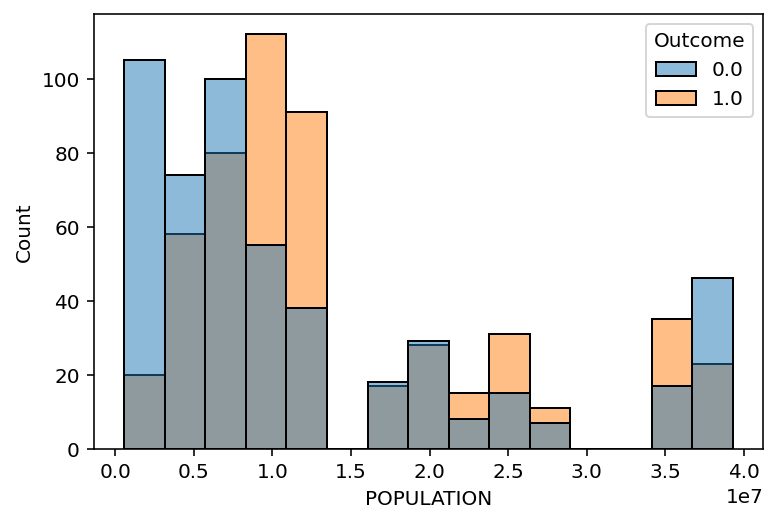

In [12]:
sns.histplot(data=df, x="POPULATION", hue="Outcome")

In [13]:
df.columns

Index(['YEAR', 'MONTH', 'NERC.REGION', 'CLIMATE.REGION', 'ANOMALY.LEVEL',
       'CLIMATE.CATEGORY', 'CAUSE.CATEGORY', 'OUTAGE.DURATION',
       'CUSTOMERS.AFFECTED', 'RES.PRICE', 'COM.PRICE', 'IND.PRICE',
       'TOTAL.PRICE', 'RES.SALES', 'COM.SALES', 'IND.SALES', 'TOTAL.SALES',
       'RES.PERCEN', 'COM.PERCEN', 'IND.PERCEN', 'RES.CUSTOMERS',
       'COM.CUSTOMERS', 'IND.CUSTOMERS', 'TOTAL.CUSTOMERS', 'RES.CUST.PCT',
       'COM.CUST.PCT', 'IND.CUST.PCT', 'PC.REALGSP.STATE', 'PC.REALGSP.USA',
       'PC.REALGSP.REL', 'PC.REALGSP.CHANGE', 'UTIL.REALGSP', 'TOTAL.REALGSP',
       'UTIL.CONTRI', 'PI.UTIL.OFUSA', 'POPULATION', 'POPPCT_URBAN',
       'POPPCT_UC', 'POPDEN_URBAN', 'POPDEN_UC', 'POPDEN_RURAL',
       'AREAPCT_URBAN', 'AREAPCT_UC', 'PCT_LAND', 'PCT_WATER_TOT',
       'PCT_WATER_INLAND', 'OUTAGE.START', 'OUTAGE.RESTORATION', 'Outcome'],
      dtype='object', name=4)

In [14]:
Q1 = df['POPULATION'].quantile(q = 0.25)
Q2 = df['POPULATION'].quantile(q = 0.5)
Q3 = df['POPULATION'].quantile(q = 0.75)
def convert(x):
    if x <= Q1:
        return "Very_Little_People"
    elif x <= Q2:
        return "Little_People"
    elif x <= Q3:
        return "Many_People"
    else:
        return "Very_Many_People"
df['POPULATION'] = df['POPULATION'].apply(convert)
# do a training test split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
steps = []
for col in df.columns:
    data_type = type(df[col].iloc[0])
    if data_type == str:
        steps.append((col,OneHotEncoder(handle_unknown='ignore'),[col]))

col_t = ('col_trans',ColumnTransformer(steps))
pl = Pipeline([col_t,('tree', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
train_accuracy = pl.score(X_train, y_train)
test_accuracy = pl.score(X_test, y_test)
train_accuracy, test_accuracy

(0.8271092669432918, 0.7419354838709677)

From baseline model, we identify the feature 'IND.CUST.PCTA' as one of the most impactful feature when predicting our outcomes. As we can see from the plot below, there is a skewness in the data with large values, thus, applying log transformation to this feature will make this feature more usable for our model. 

<AxesSubplot:xlabel='OBS'>

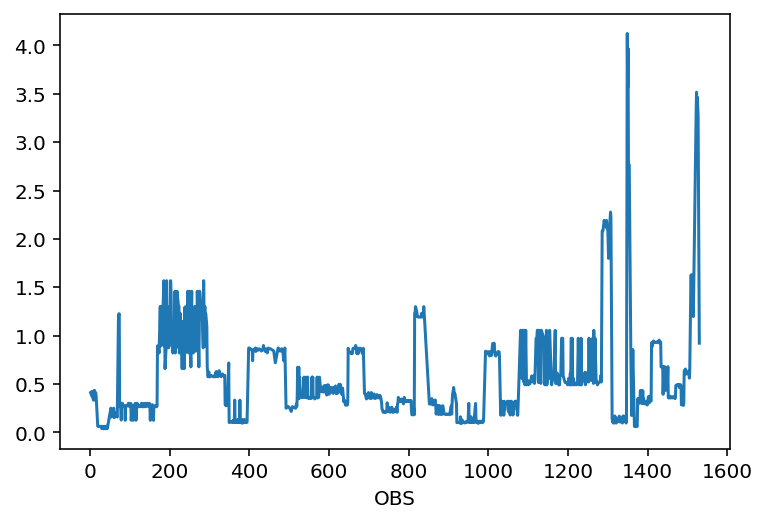

In [15]:
df['IND.CUST.PCT'].plot()

We can see a higher accuracy after applying log transformation to IND.CUST.PCT. The testing accuracy jumps from around 70% to 76% after we apply grid search to find the best parameters!

In [16]:
# do a training test split
X = df.drop('Outcome', axis=1)
y = df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
steps = [('log_trans',FunctionTransformer(np.log),['IND.CUST.PCT'])]
for col in df.columns:
    data_type = type(df[col].iloc[0])
    if data_type == str:
        steps.append((col,OneHotEncoder(handle_unknown='ignore'),[col]))

col_t = ('col_trans',ColumnTransformer(steps))
pl = Pipeline([col_t,('tree', DecisionTreeClassifier())])

pl.fit(X_train, y_train)
train_accuracy = pl.score(X_train, y_train)
test_accuracy = pl.score(X_test, y_test)
train_accuracy, test_accuracy

(0.9156293222683264, 0.7193548387096774)

We then used gridsearch to avoid overfitting.

In [17]:
parameter = {'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,None]}
clf = GridSearchCV(estimator=pl, param_grid=parameter, cv = 5)
clf.fit(X_train, y_train)
clf.best_params_

{'tree__max_depth': 1}

In [18]:
test_accuracy = clf.score(X_test, y_test)
clf.best_score_, test_accuracy

(0.7607758620689655, 0.7193548387096774)

### Fairness Evaluation

In this section we want to check if our model is fair when evaluating the severity in coastal and inland states. (based on this [https://en.wikipedia.org/wiki/List_of_U.S._states_and_territories_by_coastline])

- Null Hypothesis: our model is fair, as the precision for my two subsets are roughly the same
- Alternative Hypothesis: our model is unfair, as the precision for the 'coastal' subset is different from the "inland" subset

In [19]:
# accuracy
clf.score(X_train,y_train)

0.7607192254495159

In [20]:
# confusion matrix
preds = clf.predict(X_test)
metrics.confusion_matrix(y_test, preds) / len(preds)

array([[0.2516129 , 0.21935484],
       [0.06129032, 0.46774194]])

In [21]:
# Recall: proportion of the number of true severe outage events predicted 
# divided by all occurence of severe outages.

metrics.recall_score(y_test, preds)

0.8841463414634146

In [22]:
# Specificity: proportion of non-servere outages that were correctly identified.

metrics.recall_score(y_test, preds, pos_label=0)

0.5342465753424658

In [23]:
# Precision: proportion of predicted severe outages that were actually severe

metrics.precision_score(y_test, preds)

0.6807511737089202

In [24]:
# FDR: proportion of predicted severe outages that are not severe

1 - metrics.precision_score(y_test, preds)

0.31924882629107976

### Calculate Parity Measures

* A = { coastal city = 'coastal' & inland city = 'inland'}
* Y = severe outage (1.0) or non-severe outage (0.0)
* C = did we predict it as severe (1.0) or not (0.0)

In [25]:
# get the U.s. State we have in the df
results = pd.concat([df, states], axis=1) # concat df with states
np.unique(results['U.S._STATE'])

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
       'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
       'Oklahoma', 'Oregon', 'Pennsylvania', 'South Carolina',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [26]:
results['is_coastal'] = (results['U.S._STATE'].isin(['Alabama', 'Arkansas', 'California', 
       'Connecticut', 'Delaware', 'Florida', 'Georgia', 
       'Indiana', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 
       'Mississippi', 'New Hampshire', 'New Jersey', 'New York', 'North Carolina',
       'South Carolina', 'Texas', 'Virginia', 'Washington'])).replace({True:'coastal', False:'inland'})
# drop states
results = results.drop(columns = ['U.S._STATE'])

In [27]:
# Drop all the remain nans in the dataset
results = results.dropna()

# do a training test split
X = results.drop('Outcome', axis=1)
y = results['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
steps = [('log_trans',FunctionTransformer(np.log),['IND.CUST.PCT'])]
for col in results.columns:
    data_type = type(results[col].iloc[0])
    if data_type == str:
        steps.append((col,OneHotEncoder(handle_unknown='ignore'),[col]))

col_t = ('col_trans',ColumnTransformer(steps))
pl = Pipeline([col_t,('tree', DecisionTreeClassifier())])

parameter = {'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,None]}
clf = GridSearchCV(estimator=pl, param_grid=parameter, cv = 5)
clf.fit(X_train, y_train)
clf.best_params_

{'tree__max_depth': 4}

In [28]:
results

4,YEAR,MONTH,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,CAUSE.CATEGORY,OUTAGE.DURATION,CUSTOMERS.AFFECTED,RES.PRICE,...,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND,OUTAGE.START,OUTAGE.RESTORATION,Outcome,is_coastal
OBS,,,,,,,,,,,,,,,,,,,,,
1,2011,7,MRO,East North Central,-0.3,normal,severe weather,3060.0,70000.0,11.60,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2011-07-01 17:00:00,2011-07-03 20:00:00,0.0,inland
3,2010,10,MRO,East North Central,-1.5,cold,severe weather,3000.0,70000.0,10.87,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-10-26 20:00:00,2010-10-28 22:00:00,0.0,inland
4,2012,6,MRO,East North Central,-0.1,normal,severe weather,2550.0,68200.0,11.79,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2012-06-19 04:30:00,2012-06-20 23:00:00,0.0,inland
5,2015,7,MRO,East North Central,1.2,warm,severe weather,1740.0,250000.0,13.07,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2015-07-18 02:00:00,2015-07-19 07:00:00,1.0,inland
6,2010,11,MRO,East North Central,-1.4,cold,severe weather,1860.0,60000.0,10.63,...,18.2,2.14,0.60,91.592666,8.407334,5.478743,2010-11-13 15:00:00,2010-11-14 22:00:00,0.0,inland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1523,2004,6,WECC,Northwest,0.3,normal,system operability disruption,95.0,35000.0,6.69,...,5.6,0.60,0.19,98.891934,1.108066,1.108066,2004-06-23 17:35:00,2004-06-23 19:10:00,0.0,inland
1524,2011,1,WECC,Northwest,-1.3,cold,intentional attack,360.0,0.0,7.82,...,5.6,0.60,0.19,98.891934,1.108066,1.108066,2011-01-23 07:00:00,2011-01-23 13:00:00,0.0,inland
1525,2003,6,WECC,Northwest,-0.1,normal,public appeal,1548.0,0.0,6.31,...,5.6,0.60,0.19,98.891934,1.108066,1.108066,2003-06-15 15:12:00,2003-06-16 17:00:00,0.0,inland


In [29]:
# Demographic Parity 
# Inland States have a better chance to encounter serious outage

preds = clf.predict(X_test)
results = X_test
results['prediction'] = preds
results['tag'] = y_test
results.groupby('is_coastal').prediction.mean().to_frame()

<ipython-input-29-62f2bea905ad>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['prediction'] = preds
<ipython-input-29-62f2bea905ad>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['tag'] = y_test


,prediction
is_coastal,
coastal,0.583756
inland,0.628319


In [30]:
# Accuracy Parity

(
    results
    .groupby('is_coastal')
    .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
    .rename('accuracy')
    .to_frame()
)

,accuracy
is_coastal,
coastal,0.710660
inland,0.716814


### Is this difference in accuracy significant?
* Use a permutation test:
    - are the distributions of severe outages "the same" for coastal/ inland groups?
    - test-statistic: "the same" is measured in terms of different notions of parity. 
        - (using 'metrics.accuracy_score()' to obtain the difference in two prediction scores)
* Set a significance level of 0.01

In [31]:
obs = results.groupby('is_coastal').apply(lambda x: metrics.accuracy_score(x.tag, x.prediction)).diff().iloc[-1]

metrs = []
# permutate 1000 times
for _ in range(100):
    s = (
        results[['is_coastal', 'prediction', 'tag']]
        .assign(is_coastal=results.is_coastal.sample(frac=1.0, replace=False).reset_index(drop=True))
        .groupby('is_coastal')
        .apply(lambda x: metrics.accuracy_score(x.tag, x.prediction))
        .diff()
        .iloc[-1]
    )
    
    metrs.append(s)

0.49


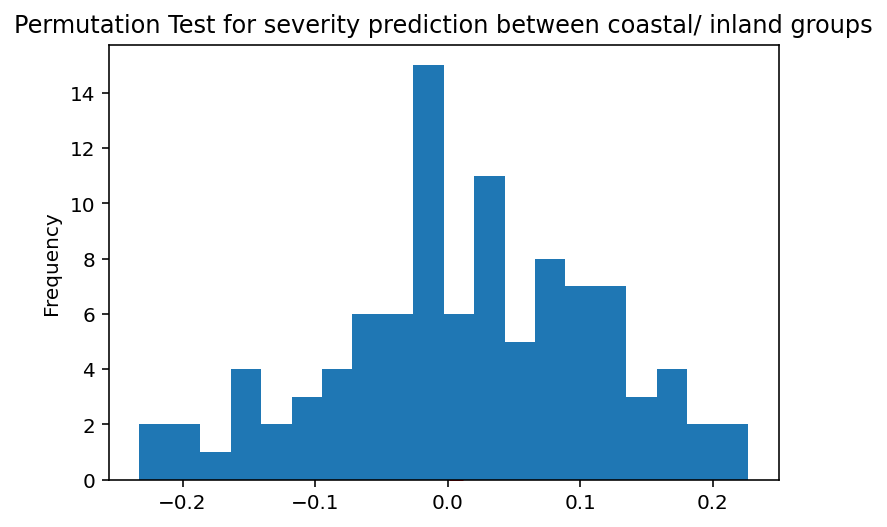

In [39]:
print(pd.Series(metrs <= obs).mean())
pd.Series(metrs).plot(kind='hist', bins=20, title='Permutation Test for severity prediction between coastal/ inland groups')
plt.scatter(obs, 0, c='r');

### Conclusion on Fairness

It seems that from our permutation test, we get a p-value of 0.49 (>0.01), which means we fail to reject the null. Hence, we will conclude that our model is fair when predicting for coastal and inland states.